<a href="https://colab.research.google.com/github/MihaelaHudisteanu/PMP-2024/blob/main/Examen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   Varsta  Sex  Educatie  Venit  Vot
0      45    1         0   8.06    1
1      39    1         1   6.48    1
2      46    1         1   5.48    1
3      55    0         0   5.61    1
4      38    1         1   5.86    1


Output()

Output()

Sampling chain 1, 0 divergences ━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  26% 0:00:03 / 0:00:01

Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━  81% 0:00:01 / 0:00:02

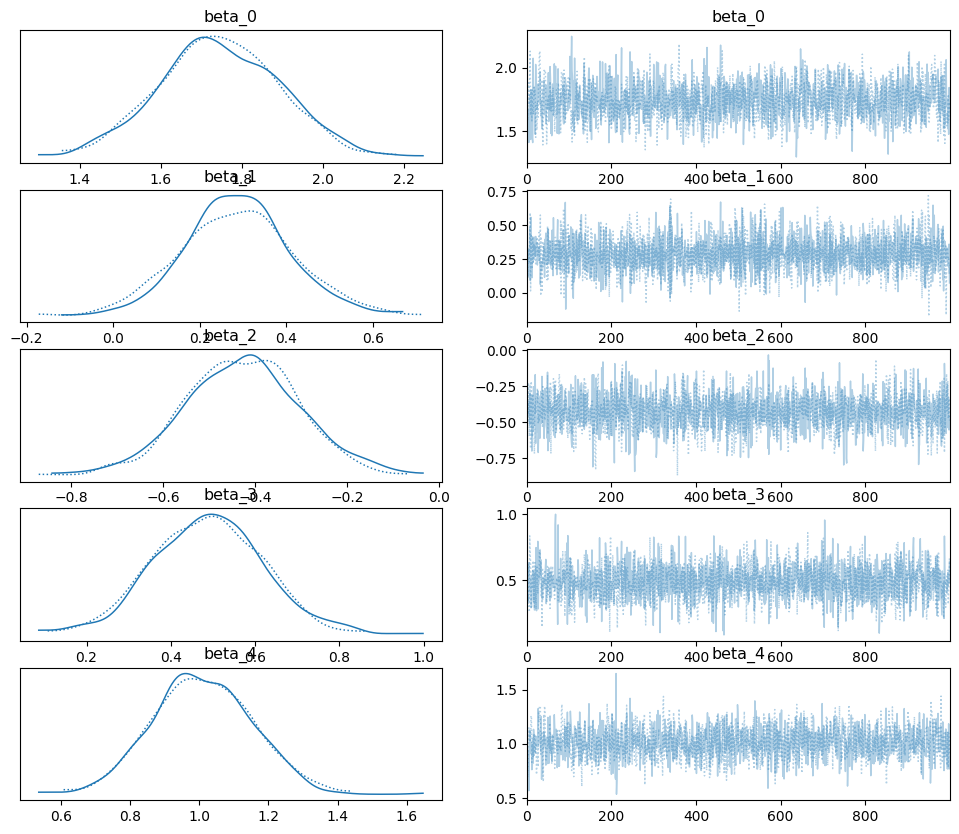

In [13]:
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az


data = pd.read_csv("date_alegeri_turul2.csv")
print(data.head())

x1 = data['Varsta'].values
x2 = data['Sex'].values
x3 = data['Educatie'].values
x4 = data['Venit'].values
y_obs = data['Vot'].values

x1_norm = (x1 - x1.mean()) / x1.std()
x2_norm = (x2 - x2.mean()) / x2.std()
x3_norm = (x3 - x3.mean()) / x3.std()
x4_norm = (x4 - x4.mean()) / x4.std()

#a)
with pm.Model() as logistic_model:
    beta_0 = pm.Normal('beta_0', mu=0, sigma=10)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=2)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=2)
    beta_3 = pm.Normal('beta_3', mu=0, sigma=2)
    beta_4 = pm.Normal('beta_4', mu=0, sigma=2)

    mu = beta_0 + beta_1 * x1_norm + beta_2 * x2_norm + beta_3 * x3_norm + beta_4 * x4_norm
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    #theta = 1/2 = logistic(beta_0 + beta_1*x1 + beta_2*x2) <-> x2 = - beta_0/beta_2 - beta_1/beta_2*x1
    #bd = pm.Deterministic('bd', - beta_0/beta_2 - beta_1/beta_2 * x1_norm)

    y = pm.Bernoulli('y', p=theta, observed=y_obs)

    idataa = pm.sample(1000, return_inferencedata=True)

az.plot_trace(idataa, var_names=['beta_0', 'beta_1', 'beta_2', 'beta_3', 'beta_4'])
plt.show()


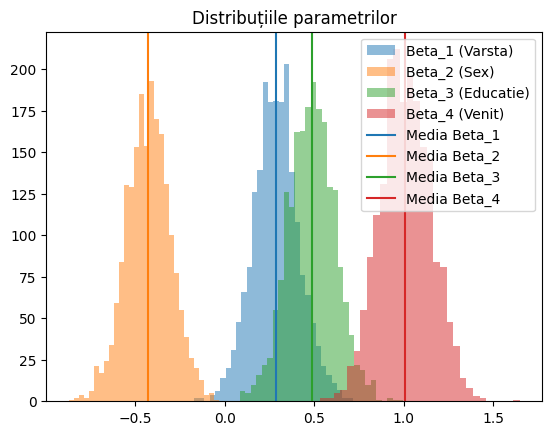

In [14]:
#b)
#pentru a vedea cine influenteaza  mai mult promovabilitatea, trebuie sa vedem cine este mai mare (in valoare absoluta)

beta_1_samples = idataa.posterior['beta_1'].values.flatten()
beta_2_samples = idataa.posterior['beta_2'].values.flatten()
beta_3_samples = idataa.posterior['beta_3'].values.flatten()
beta_4_samples = idataa.posterior['beta_4'].values.flatten()

beta_1_mean = beta_1_samples.mean()
beta_2_mean = beta_2_samples.mean()
beta_3_mean = beta_3_samples.mean()
beta_4_mean = beta_4_samples.mean()

plt.hist(beta_1_samples, bins=30, alpha=0.5, label='Beta_1 (Varsta)', color='C0')
plt.hist(beta_2_samples, bins=30, alpha=0.5, label='Beta_2 (Sex)', color='C1')
plt.hist(beta_3_samples, bins=30, alpha=0.5, label='Beta_3 (Educatie)', color='C2')
plt.hist(beta_4_samples, bins=30, alpha=0.5, label='Beta_4 (Venit)', color='C3')
plt.axvline(beta_1_mean, color='C0',  label=f"Media Beta_1")
plt.axvline(beta_2_mean, color='C1', label=f"Media Beta_2")
plt.axvline(beta_3_mean, color='C2', label=f"Media Beta_3")
plt.axvline(beta_4_mean, color='C3', label=f"Media Beta_4")

plt.title("Distribuțiile parametrilor")
plt.legend()
plt.show()

#deci educatia si venitul influenteaza cel mai mult

In [19]:
#c)
with pm.Model() as logistic_model:
    beta_0 = pm.Normal('beta_0', mu=0, sigma=10)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=2)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=2)

    #folosim doar x3 si x4
    mu = beta_0 + beta_1 * x3_norm + beta_2 * x4_norm
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    #theta = 1/2 = logistic(beta_0 + beta_1*x1 + beta_2*x2) <-> x2 = - beta_0/beta_2 - beta_1/beta_2*x1
    bd = pm.Deterministic('bd', - beta_0/beta_2 - beta_1/beta_2 * x1_norm)

    y = pm.Bernoulli('y', p=theta, observed=y_obs)

    idatac = pm.sample(1000, return_inferencedata=True, target_accept=0.94)

idx = np.argsort(x3_norm)
bd = idatac.posterior['bd'].mean(("chain", "draw"))[idx]

plt.scatter(x3_norm, x4_norm, marker='.', color=[f'C{x}' for x in y_obs])

plt.plot(x3_norm[idx], bd, color='k')


az.plot_hdi(x3_norm, idatac.posterior['bd'], color='k', hdi_prob=0.94)

locs_x, _ = plt.xticks()
plt.xticks(locs_x, np.round(locs_x * x3.std() + x3.mean(), 1))

locs_y, _ = plt.yticks()
plt.yticks(locs_y, np.round(locs_y * x4.std() + x4.mean(), 1))

plt.xlabel('edu')
plt.ylabel('venit')
plt.show()


#variabile nu sunt indeajuns

Sampling chain 0, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━  97% 0:00:01 / 0:00:02

Output()

In [20]:
#d)
waic_a = az.waic(idataa)
waic_c = az.waic(idatac)
loo_a = az.loo(idataa)
loo_c = az.loo(idatac)

# Comparare
cmp_df = az.compare({'a': idataa, 'c': idatac}, ic="waic")
az.plot_compare(cmp_df)
plt.show()

Sampling chain 0, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 100% 0:00:01 / 0:00:18

Output()

Sampling chain 1, 0 divergences ━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━  31% 0:00:16 / 0:00:06

Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━  47% 0:00:11 / 0:00:09

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>],
       [<Axes: title={'center': 'means'}>,
        <Axes: title={'center': 'means'}>]], dtype=object)

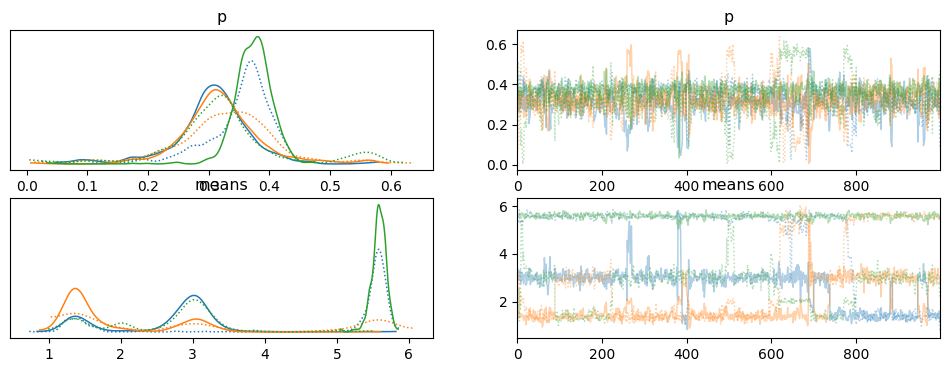

In [23]:
#2
iris = pd.read_csv("iris.csv")
print(iris.head())

x1 = iris['sepal_length'].values
x2 = iris['sepal_width'].values
x3 = iris['petal_length'].values
x4 = iris['petal_width'].values
#y_obs = iris['species'].values

x = np.concatenate([x1, x2, x3, x4])

# Model mixtură
clusters = 3
with pm.Model() as model_mixture:
    p = pm.Dirichlet('p', a=np.ones(clusters))

    # Medii și deviații standard
    means = pm.Normal('means', mu=x.mean(), sigma=10, shape=clusters)
    sd = pm.HalfNormal('sigma', sigma=10)

    # Mixtura Gaussiană
    y = pm.NormalMixture('y', w=p, mu=means, sigma=sd, observed=x)

    # Eșantionare
    idata_mg = pm.sample(random_seed=123, return_inferencedata=True)

# Rezultate
az.plot_trace(idata_mg, var_names=['p', 'means'])

In [ ]:
#b)
#putem face cate un model cu fiecrae caracteristica si apoi sa le comparam sau putem scoate pe rand cate o caracteristica

In [ ]:
x = np.concatenate([x2, x3, x4])

# Model mixtură
clusters = 3
with pm.Model() as model_mixture:
    p = pm.Dirichlet('p', a=np.ones(clusters))

    # Medii și deviații standard
    means = pm.Normal('means', mu=x.mean(), sigma=10, shape=clusters)
    sd = pm.HalfNormal('sigma', sigma=10)

    # Mixtura Gaussiană
    y = pm.NormalMixture('y', w=p, mu=means, sigma=sd, observed=x)

    # Eșantionare
    idata_mg = pm.sample(random_seed=123, return_inferencedata=True)

# Rezultate
az.plot_trace(idata_mg, var_names=['p', 'means'])


Sampling chain 1, 0 divergences ━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━  30% 0:00:12 / 0:00:05

ERROR:pymc.stats.convergence:There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>],
       [<Axes: title={'center': 'means'}>,
        <Axes: title={'center': 'means'}>]], dtype=object)

In [ ]:
x = np.concatenate([x1, x3, x4])

# Model mixtură
clusters = 3
with pm.Model() as model_mixture:
    p = pm.Dirichlet('p', a=np.ones(clusters))

    # Medii și deviații standard
    means = pm.Normal('means', mu=x.mean(), sigma=10, shape=clusters)
    sd = pm.HalfNormal('sigma', sigma=10)

    # Mixtura Gaussiană
    y = pm.NormalMixture('y', w=p, mu=means, sigma=sd, observed=x)

    # Eșantionare
    idata_mg = pm.sample(random_seed=123, return_inferencedata=True)

# Rezultate
az.plot_trace(idata_mg, var_names=['p', 'means'])

Sampling chain 0, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━  59% 0:00:05 / 0:00:07

Output()

Sampling chain 1, 0 divergences ━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━  32% 0:00:07 / 0:00:02

Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━  87% 0:00:01 / 0:00:06

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>],
       [<Axes: title={'center': 'means'}>,
        <Axes: title={'center': 'means'}>]], dtype=object)

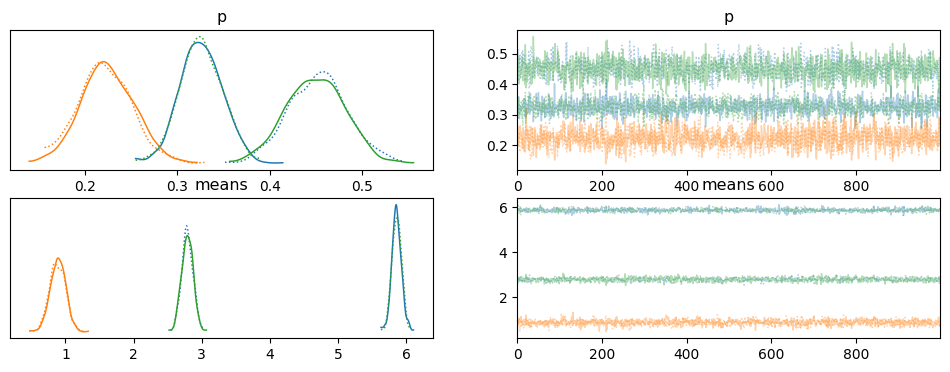

In [26]:
x = np.concatenate([x3])

# Model mixtură
clusters = 3
with pm.Model() as model_mixture:
    p = pm.Dirichlet('p', a=np.ones(clusters))

    # Medii și deviații standard
    means = pm.Normal('means', mu=x.mean(), sigma=10, shape=clusters)
    sd = pm.HalfNormal('sigma', sigma=10)

    # Mixtura Gaussiană
    y = pm.NormalMixture('y', w=p, mu=means, sigma=sd, observed=x)

    # Eșantionare
    idata_mg = pm.sample(random_seed=123, return_inferencedata=True)

# Rezultate
az.plot_trace(idata_mg, var_names=['p', 'means'])

In [27]:
x = np.concatenate([x4])

# Model mixtură
clusters = 3
with pm.Model() as model_mixture:
    p = pm.Dirichlet('p', a=np.ones(clusters))

    # Medii și deviații standard
    means = pm.Normal('means', mu=x.mean(), sigma=10, shape=clusters)
    sd = pm.HalfNormal('sigma', sigma=10)

    # Mixtura Gaussiană
    y = pm.NormalMixture('y', w=p, mu=means, sigma=sd, observed=x)

    # Eșantionare
    idata_mg = pm.sample(random_seed=123, return_inferencedata=True)

# Rezultate
az.plot_trace(idata_mg, var_names=['p', 'means'])

Sampling chain 0, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━  90% 0:00:06 / 0:00:48